In [1]:
# XGBoost predicting features and using them to predict SP500 

In [2]:
# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import xgboost as xgb

pd.options.display.float_format = '{:,.2f}'.format

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

In [3]:
data_set = pd.read_csv("MultipleSources-2019-2025-Ascending.csv")
data_set.head()
data_set.tail()

,Date,SP500,Futures,Nikkei,FTSE,DAX
0,04/03/19,"2,873.40","2,879.75","21,713.21","7,418.28","11,954.40"
1,04/04/19,"2,879.39","2,882.75","21,724.95","7,401.94","11,988.01"
2,04/05/19,"2,892.74","2,896.00","21,807.50","7,446.87","12,009.75"
3,04/08/19,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40"
4,04/09/19,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57"


,Date,SP500,Futures,Nikkei,FTSE,DAX
1511,04/07/25,"5,062.25","5,149.75","31,136.58","7,702.08","19,789.62"
1512,04/08/25,"4,982.77","5,020.25","33,012.58","7,910.53","20,280.26"
1513,04/09/25,"5,456.90","5,491.00","31,714.03","7,679.48","19,670.88"
1514,04/10/25,"5,268.05","5,302.00","34,609.00","7,913.25","20,562.73"
1515,04/11/25,"5,363.36","5,391.25","33,585.58","7,964.18","20,374.10"


In [4]:
data_set.columns

data_set.tail()

# Step 1: Ensure the 'Date' column is in datetime format
data_set['Date'] = pd.to_datetime(data_set['Date'], format='%m/%d/%y')

data_set.tail()

# Step 2: Convert datetime to integer timestamp (in seconds)
data_set['Date'] = data_set['Date'].astype(np.int64) // 10**9

data_set.tail()




Index(['Date', 'SP500', 'Futures', 'Nikkei', 'FTSE', 'DAX'], dtype='object')

,Date,SP500,Futures,Nikkei,FTSE,DAX
1511,04/07/25,"5,062.25","5,149.75","31,136.58","7,702.08","19,789.62"
1512,04/08/25,"4,982.77","5,020.25","33,012.58","7,910.53","20,280.26"
1513,04/09/25,"5,456.90","5,491.00","31,714.03","7,679.48","19,670.88"
1514,04/10/25,"5,268.05","5,302.00","34,609.00","7,913.25","20,562.73"
1515,04/11/25,"5,363.36","5,391.25","33,585.58","7,964.18","20,374.10"


,Date,SP500,Futures,Nikkei,FTSE,DAX
1511,2025-04-07,"5,062.25","5,149.75","31,136.58","7,702.08","19,789.62"
1512,2025-04-08,"4,982.77","5,020.25","33,012.58","7,910.53","20,280.26"
1513,2025-04-09,"5,456.90","5,491.00","31,714.03","7,679.48","19,670.88"
1514,2025-04-10,"5,268.05","5,302.00","34,609.00","7,913.25","20,562.73"
1515,2025-04-11,"5,363.36","5,391.25","33,585.58","7,964.18","20,374.10"


,Date,SP500,Futures,Nikkei,FTSE,DAX
1511,1743984000,"5,062.25","5,149.75","31,136.58","7,702.08","19,789.62"
1512,1744070400,"4,982.77","5,020.25","33,012.58","7,910.53","20,280.26"
1513,1744156800,"5,456.90","5,491.00","31,714.03","7,679.48","19,670.88"
1514,1744243200,"5,268.05","5,302.00","34,609.00","7,913.25","20,562.73"
1515,1744329600,"5,363.36","5,391.25","33,585.58","7,964.18","20,374.10"


In [5]:
def add_lag_features(df, columns, lags):
    """
    Adds lag features for given columns and lag days.

    Parameters:
    df (pd.DataFrame): Original dataset
    columns (list): Columns for which to create lag features
    lags (list): List of lag values (e.g., [1, 2, 3])

    Returns:
    pd.DataFrame: Dataset with new lag features
    """
    for col in columns:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df


lag_columns = ['SP500', 'DAX', 'FTSE', 'Nikkei']
lag_days = [1, 2, 3] 

data_set = add_lag_features(data_set, lag_columns, lag_days)
data_set = data_set.dropna()  # Drop rows with NaNs from lags
data_set.head()
data_set.tail()

#data_set = data_set.sort_values(by='Date').reset_index(drop=True)



,Date,SP500,Futures,Nikkei,FTSE,DAX,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
3,1554681600,"2,895.77","2,898.25","21,761.65","7,451.89","11,963.40","2,892.74","2,879.39","2,873.40","12,009.75","11,988.01","11,954.40","7,446.87","7,401.94","7,418.28","21,807.50","21,724.95","21,713.21"
4,1554768000,"2,878.20","2,882.50","21,802.59","7,425.57","11,850.57","2,895.77","2,892.74","2,879.39","11,963.40","12,009.75","11,988.01","7,451.89","7,446.87","7,401.94","21,761.65","21,807.50","21,724.95"
5,1554854400,"2,888.21","2,894.50","21,687.57","7,421.91","11,905.91","2,878.20","2,895.77","2,892.74","11,850.57","11,963.40","12,009.75","7,425.57","7,451.89","7,446.87","21,802.59","21,761.65","21,807.50"
6,1554940800,"2,888.32","2,891.75","21,711.38","7,417.95","11,935.20","2,888.21","2,878.20","2,895.77","11,905.91","11,850.57","11,963.40","7,421.91","7,425.57","7,451.89","21,687.57","21,802.59","21,761.65"
7,1555027200,"2,907.41","2,912.50","21,870.56","7,437.06","11,999.93","2,888.32","2,888.21","2,878.20","11,935.20","11,905.91","11,850.57","7,417.95","7,421.91","7,425.57","21,711.38","21,687.57","21,802.59"


,Date,SP500,Futures,Nikkei,FTSE,DAX,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
1511,1743984000,"5,062.25","5,149.75","31,136.58","7,702.08","19,789.62","5,074.08","5,396.52","5,670.97","20,641.72","21,717.39","22,390.84","8,054.98","8,474.74","8,608.48","33,780.58","34,735.93","35,725.87"
1512,1744070400,"4,982.77","5,020.25","33,012.58","7,910.53","20,280.26","5,062.25","5,074.08","5,396.52","19,789.62","20,641.72","21,717.39","7,702.08","8,054.98","8,474.74","31,136.58","33,780.58","34,735.93"
1513,1744156800,"5,456.90","5,491.00","31,714.03","7,679.48","19,670.88","4,982.77","5,062.25","5,074.08","20,280.26","19,789.62","20,641.72","7,910.53","7,702.08","8,054.98","33,012.58","31,136.58","33,780.58"
1514,1744243200,"5,268.05","5,302.00","34,609.00","7,913.25","20,562.73","5,456.90","4,982.77","5,062.25","19,670.88","20,280.26","19,789.62","7,679.48","7,910.53","7,702.08","31,714.03","33,012.58","31,136.58"
1515,1744329600,"5,363.36","5,391.25","33,585.58","7,964.18","20,374.10","5,268.05","5,456.90","4,982.77","20,562.73","19,670.88","20,280.26","7,913.25","7,679.48","7,910.53","34,609.00","31,714.03","33,012.58"


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_set.drop(columns = ['SP500']), data_set['SP500'], test_size=0.2, random_state=50)
X_train
X_test
y_train
y_test

,Date,Futures,Nikkei,FTSE,DAX,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
328,1595376000,"3,265.50","22,751.61","6,207.10","13,104.25","3,257.30","3,251.84","3,224.73","13,171.83","13,046.92","12,919.61","6,269.73","6,261.52","6,290.30","22,884.22","22,717.48","22,696.42"
1295,1716508800,"5,321.50","38,646.11","8,317.59","18,693.37","5,267.84","5,307.01","5,321.41","18,691.32","18,680.20","18,726.76","8,339.23","8,370.33","8,416.45","39,103.22","38,617.10","38,946.93"
561,1624492800,"4,256.00","28,875.23","7,109.97","15,589.23","4,241.84","4,246.44","4,224.79","15,456.39","15,636.33","15,603.24","7,074.06","7,090.01","7,062.29","28,874.89","28,884.13","28,010.93"
774,1651104000,"4,283.50","26,847.90","7,509.19","13,979.84","4,183.96","4,175.20","4,296.12","13,793.94","13,756.40","13,924.17","7,425.61","7,386.19","7,380.54","26,386.63","26,700.11","26,590.78"
412,1605657600,"3,565.00","25,728.14","6,385.24","13,201.89","3,609.53","3,626.91","3,585.15","13,133.47","13,138.61","13,076.72","6,365.33","6,421.29","6,316.39","26,014.62","25,906.93","25,385.87"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,1744156800,"5,491.00","31,714.03","7,679.48","19,670.88","4,982.77","5,062.25","5,074.08","20,280.26","19,789.62","20,641.72","7,910.53","7,702.08","8,054.98","33,012.58","31,136.58","33,780.58"
335,1596153600,"3,263.50","21,710.00","5,897.76","12,313.36","3,246.22","3,258.44","3,218.44","12,379.65","12,822.26","12,835.28","5,989.99","6,131.46","6,129.26","22,339.23","22,397.11","22,657.38"
98,1566432000,"2,922.25","20,628.01","7,128.18","11,747.04","2,924.43","2,900.51","2,923.65","11,802.85","11,651.18","11,715.37","7,203.97","7,125.00","7,189.65","20,618.57","20,677.22","20,563.16"
202,1579651200,"3,319.75","24,031.35","7,571.92","13,515.75","3,320.79","3,329.62","3,316.81","13,555.87","13,526.13","13,429.43","7,610.70","7,674.56","7,609.81","23,864.56","24,041.26","23,933.13"


,Date,Futures,Nikkei,FTSE,DAX,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
353,1598400000,"3,480.25","23,290.86","6,045.60","13,190.15","3,443.62","3,431.28","3,397.16","13,061.62","13,066.54","12,764.80","6,037.01","6,104.73","6,001.89","23,296.77","22,985.51","22,920.30"
1175,1701388800,"4,600.75","33,431.51","7,529.35","16,397.52","4,567.80","4,550.58","4,554.89","16,215.43","16,166.45","15,992.67","7,453.75","7,423.46","7,455.24","33,486.89","33,321.22","33,408.39"
1061,1687305600,"4,409.25","33,575.14","7,559.18","16,023.13","4,388.71","4,409.59","4,425.84","16,111.32","16,357.63","16,290.12","7,569.31","7,642.72","7,628.26","33,388.91","33,706.08","33,485.49"
632,1633392000,"4,334.00","27,822.12","7,077.10","15,194.49","4,300.46","4,357.04","4,307.54","15,036.55","15,156.44","15,260.69","7,011.01","7,027.07","7,086.42","28,444.89","28,771.07","29,452.66"
496,1616457600,"3,899.75","28,995.92","6,699.19","14,662.02","3,940.59","3,913.10","3,915.46","14,657.21","14,621.00","14,775.52","6,726.10","6,708.71","6,779.68","29,174.15","29,792.05","30,216.75"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,1709856000,"5,129.00","39,688.94","7,659.74","17,814.51","5,157.36","5,104.76","5,078.65","17,842.85","17,716.71","17,698.40","7,692.46","7,679.31","7,646.16","39,598.71","40,090.78","40,097.63"
972,1675987200,"4,099.75","27,670.98","7,882.45","15,307.98","4,081.50","4,117.86","4,164.00","15,523.42","15,412.05","15,320.88","7,911.15","7,885.17","7,864.71","27,584.35","27,606.46","27,685.47"
1486,1740960000,"5,860.75","37,785.47","8,871.31","23,147.02","5,954.50","5,861.57","5,956.06","22,551.43","22,550.89","22,794.11","8,809.74","8,756.21","8,731.46","37,155.50","38,256.17","38,142.37"
405,1604880000,"3,544.00","24,839.84","6,186.29","13,095.97","3,509.44","3,510.45","3,443.44","12,480.02","12,568.09","12,324.22","5,910.02","5,906.18","5,883.26","24,325.23","24,105.28","23,695.23"


328    3,276.02
1295   5,304.72
561    4,266.49
774    4,287.50
412    3,567.79
         ...   
1513   5,456.90
335    3,271.12
98     2,922.95
202    3,321.75
165    3,140.52
Name: SP500, Length: 879, dtype: float64

353    3,478.73
1175   4,594.63
1061   4,365.69
632    4,345.72
496    3,910.52
         ...   
1241   5,123.69
972    4,090.46
1486   5,849.72
405    3,550.50
1046   4,205.52
Name: SP500, Length: 220, dtype: float64

In [7]:
# XGBoost comes with its own class for storing datasets called DMatrix. 
# It is a highly optimized class for memory and speed. 
# That's why converting datasets into this format is a requirement for the native XGBoost API:


# Create regression matrices

dtrain_reg = xgb.DMatrix(X_train, y_train, )#enable_categorical=True)

dtest_reg = xgb.DMatrix(X_test, y_test, )#enable_categorical=True)

params = {"objective": "reg:squarederror", "tree_method": "exact", "max_depth" : 4, "learning_rate" : 0.1} # use "tree_method" : "hist" if you need speed

In [8]:
n = 100

model = xgb.train(

   params=params,

   dtrain=dtrain_reg,

   num_boost_round=n,

)

In [9]:
from sklearn.metrics import mean_squared_error
preds = model.predict(dtest_reg)


In [10]:
test_output = pd.DataFrame(preds, index = X_test.index, columns = ['pred_spx'])
test_output = test_output.merge(y_test, left_index = True, right_index = True)
test_output.head()
mean_absolute_error = abs(test_output['pred_spx'] - test_output['SP500']).mean()
print('Mean absolute error is ')
print(mean_absolute_error)
xg = abs(test_output['pred_spx'] - test_output['SP500']).mean()/test_output['SP500'].mean()
print(xg)

XGBmodel = model # for later use

,pred_spx,SP500
353,"3,480.51","3,478.73"
1175,"4,579.71","4,594.63"
1061,"4,384.38","4,365.69"
632,"4,330.03","4,345.72"
496,"3,907.25","3,910.52"


Mean absolute error is 
11.484481667258507
0.0026930260159918323


In [11]:
# create models for predicting each feature

feature_models = {}
lag_features = data_set.filter(like='lag', axis=1)
lag_features

for feature in ['Futures', 'Nikkei', 'FTSE', 'DAX']:
    df_feat = data_set[[feature]].copy()
#    df_feat['lag'] = df_feat[feature].shift(lag)
    df_feat.dropna(inplace=True)

    X = df_feat[lag_features].values
    y = df_feat[feature].values

    dtrain = xgb.DMatrix(X, label=y)
    model = xgb.train(params, dtrain, num_boost_round=100)
    feature_models[feature] = model


feature_models


,SP500_lag_1,SP500_lag_2,SP500_lag_3,DAX_lag_1,DAX_lag_2,DAX_lag_3,FTSE_lag_1,FTSE_lag_2,FTSE_lag_3,Nikkei_lag_1,Nikkei_lag_2,Nikkei_lag_3
3,"2,892.74","2,879.39","2,873.40","12,009.75","11,988.01","11,954.40","7,446.87","7,401.94","7,418.28","21,807.50","21,724.95","21,713.21"
4,"2,895.77","2,892.74","2,879.39","11,963.40","12,009.75","11,988.01","7,451.89","7,446.87","7,401.94","21,761.65","21,807.50","21,724.95"
5,"2,878.20","2,895.77","2,892.74","11,850.57","11,963.40","12,009.75","7,425.57","7,451.89","7,446.87","21,802.59","21,761.65","21,807.50"
6,"2,888.21","2,878.20","2,895.77","11,905.91","11,850.57","11,963.40","7,421.91","7,425.57","7,451.89","21,687.57","21,802.59","21,761.65"
7,"2,888.32","2,888.21","2,878.20","11,935.20","11,905.91","11,850.57","7,417.95","7,421.91","7,425.57","21,711.38","21,687.57","21,802.59"
...,...,...,...,...,...,...,...,...,...,...,...,...
1511,"5,074.08","5,396.52","5,670.97","20,641.72","21,717.39","22,390.84","8,054.98","8,474.74","8,608.48","33,780.58","34,735.93","35,725.87"
1512,"5,062.25","5,074.08","5,396.52","19,789.62","20,641.72","21,717.39","7,702.08","8,054.98","8,474.74","31,136.58","33,780.58","34,735.93"
1513,"4,982.77","5,062.25","5,074.08","20,280.26","19,789.62","20,641.72","7,910.53","7,702.08","8,054.98","33,012.58","31,136.58","33,780.58"
1514,"5,456.90","4,982.77","5,062.25","19,670.88","20,280.26","19,789.62","7,679.48","7,910.53","7,702.08","31,714.03","33,012.58","31,136.58"


{'Futures': <xgboost.core.Booster at 0x7f45227896d0>,
 'Nikkei': <xgboost.core.Booster at 0x7f4522789d10>,
 'FTSE': <xgboost.core.Booster at 0x7f452273f490>,
 'DAX': <xgboost.core.Booster at 0x7f452273ed70>}

In [12]:
single_day = pd.Timedelta('1day')
#print(f"1 day datetime: {single_day}")

#day_in_seconds = 86400
single_day = single_day.total_seconds()



# now predict future features

n_days = 7
last_known = data_set.copy()
future_features = []

for _ in range(n_days):
    prev = last_known.iloc[-1]
    next_vals = {}

    for feature in ['Futures', 'Nikkei', 'FTSE', 'DAX']:
        X_feat = np.array([[prev[feature]]])
        dmatrix_feat = xgb.DMatrix(X_feat)
        pred = feature_models[feature].predict(dmatrix_feat)[0]
        next_vals[feature] = pred

    future_features.append(next_vals)

    # Add to last_known for chaining predictions
    new_date = last_known.index[-1] + single_day
    last_known.loc[new_date] = {
        'SP500': np.nan,
        **next_vals
    }


In [23]:


def predict_sp500_with_lags(
    base_df: pd.DataFrame,
    sp500_model: xgb.Booster,
    feature_models: dict,
    forecast_days: int = 7
):
    """
    Predict future SP500 closing prices using lag features and XGBoost models.

    Parameters:
        base_df (pd.DataFrame): Historical DataFrame containing SP500, Futures, Nikkei, FTSE, DAX
        sp500_model (xgb.Booster): Pretrained XGBoost model to predict SP500
        feature_models (dict): Dictionary of XGBoost models per feature (Futures, Nikkei, FTSE, DAX)
        forecast_days (int): Number of days to forecast

    Returns:
        pd.DataFrame: Predicted SP500 prices with dates
    """

    required_features = [
        'Date', 'Futures', 'Nikkei', 'FTSE', 'DAX',
        'SP500_lag_1', 'SP500_lag_2', 'SP500_lag_3',
        'DAX_lag_1', 'DAX_lag_2', 'DAX_lag_3',
        'FTSE_lag_1', 'FTSE_lag_2', 'FTSE_lag_3',
        'Nikkei_lag_1', 'Nikkei_lag_2', 'Nikkei_lag_3'
    ]

    # Make a copy to avoid mutating original
    last_known = base_df.copy()
    #print(last_known)
    future_predictions = []

    for day in range(forecast_days):
        latest = last_known.iloc[-1]
        last_date = latest['Date']
        print(f"last date: {last_date}")
        # Predict next-day features using feature models
        next_features = {}
        for feat in ['Futures', 'Nikkei', 'FTSE', 'DAX']:
            x_input = np.array([[latest[feat]]])
            dmatrix = xgb.DMatrix(x_input)
            next_features[feat] = feature_models[feat].predict(dmatrix)[0]

        # Build lag features
        input_row = {
            'Date': last_date + single_day,
            'Futures': next_features['Futures'],
            'Nikkei': next_features['Nikkei'],
            'FTSE': next_features['FTSE'],
            'DAX': next_features['DAX'],
        }

        for lag in [1, 2, 3]:
            for lag_feat in ['SP500', 'DAX', 'FTSE', 'Nikkei']:
                input_row[f"{lag_feat}_lag_{lag}"] = last_known[lag_feat].iloc[-lag]

        # Create input DataFrame in correct column order
        input_df = pd.DataFrame([input_row])[required_features]
        input_df
        dmatrix_final = xgb.DMatrix(input_df.values, feature_names=required_features)

        # Predict SP500
        pred_sp500 = sp500_model.predict(dmatrix_final)[0]
        #print(f"prev date: {last_known['Date'].iloc[-1]}")
        #print(f"prev readable date: {pd.to_datetime(last_known['Date'].iloc[-1])}")
        pred_date = last_known['Date'].iloc[-1] + single_day
        #print(f"next day {pred_date}")

        # Save prediction
        future_predictions.append({'Date': pred_date, 'SP500': pred_sp500})

        # Append row to last_known for next iteration
        new_row = {
            'SP500': pred_sp500,
            'Futures': next_features['Futures'],
            'Nikkei': next_features['Nikkei'],
            'FTSE': next_features['FTSE'],
            'DAX': next_features['DAX']
        }
        last_known.loc[pred_date] = new_row


    
    df =  pd.DataFrame(future_predictions) #.set_index('Date')
    #df['Date'] = pd.to_datetime(df['Date'], unit='s')
    df = df.set_index('Date')
    print(df)
    return df


            Date    SP500  Futures    Nikkei     FTSE       DAX  SP500_lag_1  \
3     1554681600 2,895.77 2,898.25 21,761.65 7,451.89 11,963.40     2,892.74   
4     1554768000 2,878.20 2,882.50 21,802.59 7,425.57 11,850.57     2,895.77   
5     1554854400 2,888.21 2,894.50 21,687.57 7,421.91 11,905.91     2,878.20   
6     1554940800 2,888.32 2,891.75 21,711.38 7,417.95 11,935.20     2,888.21   
7     1555027200 2,907.41 2,912.50 21,870.56 7,437.06 11,999.93     2,888.32   
...          ...      ...      ...       ...      ...       ...          ...   
1511  1743984000 5,062.25 5,149.75 31,136.58 7,702.08 19,789.62     5,074.08   
1512  1744070400 4,982.77 5,020.25 33,012.58 7,910.53 20,280.26     5,062.25   
1513  1744156800 5,456.90 5,491.00 31,714.03 7,679.48 19,670.88     4,982.77   
1514  1744243200 5,268.05 5,302.00 34,609.00 7,913.25 20,562.73     5,456.90   
1515  1744329600 5,363.36 5,391.25 33,585.58 7,964.18 20,374.10     5,268.05   

      SP500_lag_2  SP500_lag_3  DAX_lag

<Axes: title={'center': 'Predicted S&P 500 for Next 7 Days'}, xlabel='Date', ylabel='Price'>

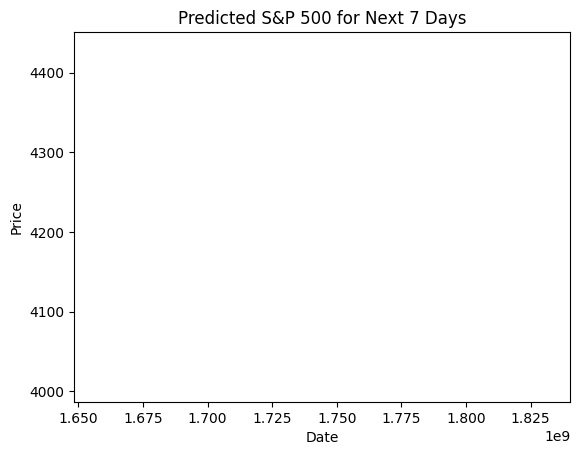

In [24]:
future_df = predict_sp500_with_lags(
    base_df=data_set,  # your full historical DataFrame
    sp500_model=XGBmodel,  # your trained SP500 XGBoost model
    feature_models=feature_models,  # dict of models for Futures, Nikkei, FTSE, DAX
    forecast_days=7
)

#print(future_df)
#future_df[''] #= pd.to_datetime(future_df['Date'], unit='s')
#prediction_readable = []
#for date in future_df['Date']:
#    prediction_readable.append(pd.to_datetime(date, unit="s"))
# data_set.set_index('Date', inplace=True)
#data_set.tail()

#print(f"Prediction Dates: {prediction_readable}")




# Optional: plot
future_df.plot(title='Predicted S&P 500 for Next 7 Days', ylabel='Price', legend=False)
